In [5]:
'''
from google.colab import drive
drive.mount('/content/gdrive')
file_path = 'gdrive/My Drive/ColabNotebooks/Seahorse/' 
'''

"\nfrom google.colab import drive\ndrive.mount('/content/gdrive')\nfile_path = 'gdrive/My Drive/ColabNotebooks/Seahorse/' \n"

In [1]:
import pandas as pd
import numpy as np
import scipy.signal
from sys import getsizeof
import matplotlib.pyplot as plt
import re 

In [2]:
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Flatten, Activation, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.models import Sequential, Model, clone_model
from keras.utils import np_utils
from keras.utils import to_categorical

Using TensorFlow backend.


## try CNN model using 2D data (oscillator/price/macd plots)

In [6]:
def normalize_data(data): 
    for i in range(data.shape[0]): 
        row = data.iloc[i, :] 
        data.iloc[i, :] = (row - min(row))/(max(row) - min(row)) 
    return data

In [7]:
class StockData():
    def __init__(self, file_path):
        '''
        input parameter "file_path" refers to the data file that contains all of the cleaned data, including oscillator, price, macd, return, symbol and label. 
        '''
        data = pd.read_csv(file_path, header=0, index_col=0) 
        print("read_csv done")
        
        pos_data = data[data['label'] == 1]
        neg_data = data[data['label'] == 0]
        
        sample_size = 12000
        pos_data = pos_data.sample(int(sample_size/2))
        neg_data = neg_data.sample(int(sample_size/2))
        data = pd.concat([pos_data, neg_data], axis = 0)
        data = data.reset_index(drop = True) 
         
        osc_normalized = normalize_data(data.iloc[:, :41])
        print("normalize osc done")
        prc_normalized = normalize_data(data.iloc[:, 41:82])
        print("normalize prc done")
        macd_normalized = normalize_data(data.iloc[:, 82:123])
        print("normalize macd done")
        rtn = data['rtn']
        X = pd.concat([osc_normalized, prc_normalized, macd_normalized, rtn], axis=1)
        y = data['label']
        
        X_train_valid_w_rtn, X_test_w_rtn, y_train_valid, y_test = train_test_split(X, y, test_size=0.25) 
        # train_valid set
        self.train_valid_rtn = X_train_valid_w_rtn['rtn']
        self.X_train_valid = X_train_valid_w_rtn.drop(['rtn'], axis = 1)
        self.y_train_valid = y_train_valid
        
        X_train_w_rtn, X_valid_w_rtn, y_train, y_valid = train_test_split(X_train_valid_w_rtn, y_train_valid, test_size=0.25) 
        # training set 
        self.train_rtn = X_train_w_rtn['rtn'] 
        self.X_train = X_train_w_rtn.drop(['rtn'], axis = 1)
        self.y_train = y_train
        # validation set
        self.valid_rtn = X_valid_w_rtn['rtn']
        self.X_valid = X_valid_w_rtn.drop(['rtn'], axis = 1) 
        self.y_valid = y_valid
        # test set 
        self.test_rtn = X_test_w_rtn['rtn']
        self.X_test = X_test_w_rtn.drop(['rtn'], axis = 1)        
        self.y_test = y_test 

In [8]:
data = StockData('../data/D1over5.csv')
data.X_train.shape

read_csv done
normalize osc done
normalize prc done
normalize macd done


(6750, 123)

In [10]:
def data_to_img(data):
    fig, axes = plt.subplots(3, 1, sharex = True)
    fig.set_figheight(3)
    fig.set_figwidth(3)
    fig.tight_layout(pad=0)
    for i in range(3):
        axes[i].plot(range(41), data[41*i:41*(i+1)], 'black')
        axes[i].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        axes[i].spines["top"].set_visible(False)
        # axes[i].spines["bottom"].set_visible(False)
        axes[i].spines["left"].set_visible(False)
        axes[i].spines["right"].set_visible(False)
    fig.canvas.draw()
    img_arr = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img_arr = img_arr.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close()  
    return img_arr

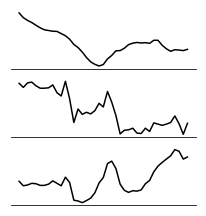

In [8]:
# explore how to convert one row of data into an image 
fig, axes = plt.subplots(3, 1, sharex = True)
fig.set_figheight(3)
fig.set_figwidth(3)
fig.tight_layout(pad=0)
for i in range(3):
    axes[i].plot(range(41), data.X_train.iloc[111, 41*i:41*(i+1)], 'black')
    axes[i].tick_params(axis = 'both', which = 'both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
    axes[i].spines["top"].set_visible(False)
    # axes[i].spines["bottom"].set_visible(False)
    axes[i].spines["left"].set_visible(False)
    axes[i].spines["right"].set_visible(False)
fig.savefig(file_path + "figtest.png")

In [11]:
# test whether the function works properly
img_arr = data_to_img(data.X_train.iloc[101, :])
img_arr.shape

(216, 216, 3)

In [12]:
# initiate X_train_img
X_train_img = []
for i in range(data.X_train.shape[0]):
  X_train_img.append(data_to_img(data.X_train.iloc[i, :123])) 
  if i%1000 == 0:
    print(i, end=' ')
print('\n')
X_train_img = np.array(X_train_img)
X_train_img.shape

0 1000 2000 3000 4000 5000 6000 



(6750, 216, 216, 3)

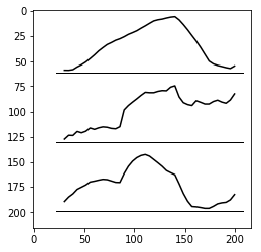

In [13]:
# check whether we get the correct X_train_img
plt.imshow(X_train_img[0,:,:,:])

In [14]:
y_train = to_categorical(data.y_train)
y_train.shape

(6750, 2)

In [15]:
# initiate X_valid_img
X_valid_img = []
for i in range(data.X_valid.shape[0]):
  X_valid_img.append(data_to_img(data.X_valid.iloc[i, :123])) 
  if i%1000 == 0:
    print(i, end=' ')
print('\n')
X_valid_img = np.array(X_valid_img)
X_valid_img.shape

0 1000 2000 



(2250, 216, 216, 3)

In [16]:
y_valid = to_categorical(data.y_valid)
y_valid.shape

(2250, 2)

In [20]:
# initiate X_test_img
X_test_img = []
for i in range(data.X_test.shape[0]):
  X_test_img.append(data_to_img(data.X_test.iloc[i, :123])) 
  if i%1000 == 0:
    print(i, end=' ')
print('\n')
X_test_img = np.array(X_test_img)
X_test_img.shape

0 1000 2000 



(3000, 216, 216, 3)

In [30]:
y_test = to_categorical(data.y_test)
y_test.shape

(3000, 2)

In [17]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(216, 216,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_img, y_train, epochs=20, verbose=1, validation_data=(X_valid_img, y_valid))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 6750 samples, validate on 2250 samples
Epoch 1/20
6750/6750 [==============================] - 133s 20ms/step - loss: 8.0352 - acc: 0.5010 - val_loss: 8.2166 - val_acc: 0.4902
Epoch 2/20
6750/6750 [==============================] - 134s 20ms/step - loss: 8.0768 - acc: 0.4951 - val_loss: 8.2166 - val_acc: 0.4902
Epoch 3/20
6750/6750 [==============================] - 135s 20ms/step - loss: 8.0281 - acc: 0.4975 - val_loss: 8.2166 - val_acc: 0.4902
Epoch 4/20
6750/6750 [==============================] - 134s 20ms/step - loss: 8.0358 - acc: 0.4975 - val_loss: 8.2166 - val_acc: 0.4902
Epoch 5/20
6750/6750 [==============================] - 132s 20ms/step - loss: 8.0132 - acc: 0.5003 - val_loss: 8.2166 - val_acc: 0.4902
Epoch 6/20
6750/6750 [==========

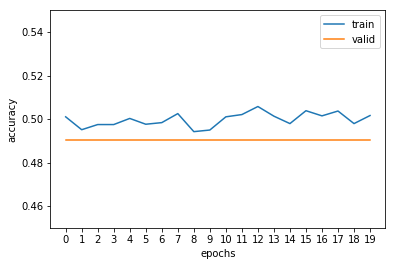

In [18]:
# results using training set and valid set 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylim(0.45, 0.55)
plt.xticks(range(0, 20))
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'valid']);

In [ ]:
# results using training set and test set 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylim(0.45, 0.55)
plt.xticks(range(0, 20))
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'test']);

In [22]:
pred = model.predict(X_test_img)

In [24]:
pred[:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [32]:
y_test[:10]

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [28]:
data.X_test.head()

,osc41,osc40,osc39,osc38,osc37,osc36,osc35,osc34,osc33,osc32,...,macd10,macd9,macd8,macd7,macd6,macd5,macd4,macd3,macd2,macd1
2890,0.088757,0.094675,0.094675,0.076923,0.100592,0.076923,0.053254,0.047337,0.047337,0.062130,...,1.000000,1.000000,0.916279,0.897674,0.981395,0.948837,0.851163,0.744186,0.748837,0.734884
10423,0.785989,0.930716,0.982294,1.000000,0.993072,0.996921,0.982294,0.865281,0.754426,0.638183,...,0.110169,0.127119,0.093220,0.084746,0.042373,0.042373,0.050847,0.033898,0.067797,0.093220
6565,0.812081,0.906040,1.000000,0.984340,0.966443,0.959732,0.973154,0.995526,0.872483,0.758389,...,0.377224,0.323843,0.341637,0.398577,0.480427,0.487544,0.501779,0.512456,0.494662,0.459075
9952,0.173469,0.204082,0.303571,0.461735,0.556122,0.670918,0.795918,0.869898,0.943878,0.992347,...,0.157191,0.143813,0.100334,0.096990,0.127090,0.137124,0.163880,0.090301,0.020067,0.066890
6164,0.130909,0.174545,0.214545,0.229091,0.265455,0.334545,0.385455,0.429091,0.458182,0.498182,...,0.334334,0.290290,0.254254,0.220220,0.197197,0.138138,0.170170,0.231231,0.301301,0.336336


In [34]:
from sklearn.metrics import precision_score, classification_report
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.51      0.68      3000
           1       0.00      0.00      0.00         0

   micro avg       0.51      0.51      0.51      3000
   macro avg       0.50      0.26      0.34      3000
weighted avg       1.00      0.51      0.68      3000
 samples avg       0.51      0.51      0.51      3000

